# Re-writing DLT to follow R. Hyndman's 

In [309]:
import pandas as pd
import matplotlib.pyplot as plt
from orbit.dlt_rh import DLTRH
from orbit.eswr import ESWR
from orbit.dlt import DLT
import numpy as np
from orbit.models import get_compiled_stan_model
from orbit.utils.plot import plot_predicted_data
from orbit.utils.plot import plot_predicted_components
from orbit.backtest.backtest import TimeSeriesSplitter, Backtest
from orbit.backtest.functions import run_multi_series_backtest

pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

In [310]:
DATA_FILE = "./data/iclaims_example.csv"

In [311]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [312]:
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [313]:
raw_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


### Train / Test Split

In [314]:
df=raw_df.copy()

In [315]:
weekly_mat = np.tile(np.eye(52), 9)[:,:df.shape[0]].transpose(1,0)
weekly_mat.shape

(443, 52)

In [316]:
weekly_labels = ["wk"  + str(x) for x in range(1,53)]

In [317]:
weekly_df = pd.DataFrame(weekly_mat, columns = weekly_labels)

In [318]:
df = pd.concat([df, weekly_df], axis=1)

In [319]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [320]:
response_col = 'claims'

In [321]:
train_df.tail(5)

,week,claims,trend.unemploy,trend.filling,trend.job,wk1,wk2,wk3,wk4,wk5,wk6,wk7,wk8,wk9,wk10,wk11,wk12,wk13,wk14,wk15,wk16,wk17,wk18,wk19,wk20,wk21,wk22,wk23,wk24,wk25,wk26,wk27,wk28,wk29,wk30,wk31,wk32,wk33,wk34,wk35,wk36,wk37,wk38,wk39,wk40,wk41,wk42,wk43,wk44,wk45,wk46,wk47,wk48,wk49,wk50,wk51,wk52
386,2017-05-28,232138,1.125745,1.042308,0.990023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
387,2017-06-04,212696,1.125745,1.023357,1.037167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388,2017-06-11,234652,1.125745,1.042308,1.001809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
389,2017-06-18,228883,1.145154,0.985455,1.025381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390,2017-06-25,239635,1.183973,1.061259,1.013595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [322]:
mod = ESWR(
    is_multiplicative=True, seed=2020,
    response_col='claims', date_col='week', 
    infer_method='map', predict_method='map',
    regressor_col=regressor_col,
)

In [323]:
mod.fit(train_df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_acd580abd53e56f5d09a81afa7c756e6 NOW.


In [324]:
fit = mod.aggregated_posteriors['map']

In [325]:
fit.keys()

dict_keys(['l', 'l_sm', 'obs_sigma', 'nu', 'gb', 'gt_sum', 'yhat', 'b_sm', 'b', 'reg'])

In [326]:
yhat_in = np.squeeze(fit['yhat'],0)

In [327]:
b = fit['b']
l = fit['l']
gb = fit['gb']
r_in = fit['reg']
b_sm = fit['b_sm']
gt_sum = fit['gt_sum']

In [328]:
l.shape

(1, 391)

In [329]:
b0 = b[:,:1,:]
b =  np.concatenate([b0, b], axis=1)
b.shape

(1, 392, 52)

In [330]:
l0 = l[:,:1]
l =  np.concatenate([l0, l], axis=1)
l.shape

(1, 392)

In [331]:
yhat2 = gt_sum + l[:,:-1] + r_in

In [332]:
yhat2[:,:10]

array([[13.38659513, 13.5056499 , 13.5359045 , 13.27780418, 13.14777391,
        13.14149555, 13.10053148, 13.01832191, 12.9897617 , 13.02431379]])

In [333]:
yhat_in[:10]

array([13.38659513, 13.5056499 , 13.5359045 , 13.27780418, 13.14777391,
       13.14149555, 13.10053148, 13.01832191, 12.9897617 , 13.02431379])

In [334]:
b_ext = np.transpose(np.tile(np.expand_dims(b[:,-1,:],-1), 51),(0,2,1))
l_ext = np.expand_dims(np.tile(l[:, -1], 51), 0)

In [335]:
l = np.concatenate([l, l_ext], axis=1)
b =  np.concatenate([b, b_ext], axis=1)

In [336]:
gt = gb * np.arange(0, l.shape[1])
gt = gt.reshape(1, -1)

In [337]:
print(l.shape, b.shape, gt.shape)

(1, 443) (1, 443, 52) (1, 443)


In [338]:
x = np.expand_dims(df[regressor_col].values,0)
x.shape

(1, 443, 52)

In [339]:
r = x * b
r = np.sum(r, axis=-1)
r.shape

(1, 443)

In [340]:
r[:,:10]

array([[ 0.15700159,  0.2778454 ,  0.30957971,  0.05362627, -0.07424904,
        -0.07886616, -0.11805551, -0.19843776, -0.22525238, -0.18912151]])

In [341]:
r_in[:,:10]

array([[ 0.15700159,  0.2778454 ,  0.30957971,  0.05362627, -0.07424904,
        -0.07886616, -0.11805551, -0.19843776, -0.22525238, -0.18912151]])

In [342]:
# this is special since l explains the initial regression
# init_reg = r[:,0]

In [343]:
# l = l - init_reg

In [344]:
print(l.shape, r.shape, gt.shape)

(1, 443) (1, 443) (1, 443)


In [345]:
yhat= gt + l + r
yhat =np.squeeze(yhat)

In [346]:
yhat.shape

(443,)

In [347]:
yhat[:10]

array([13.38659513, 13.5056499 , 13.5359045 , 13.27780418, 13.14777391,
       13.14149555, 13.10053148, 13.01832191, 12.9897617 , 13.02431379])

In [348]:
yhat_in[:10]

array([13.38659513, 13.5056499 , 13.5359045 , 13.27780418, 13.14777391,
       13.14149555, 13.10053148, 13.01832191, 12.9897617 , 13.02431379])

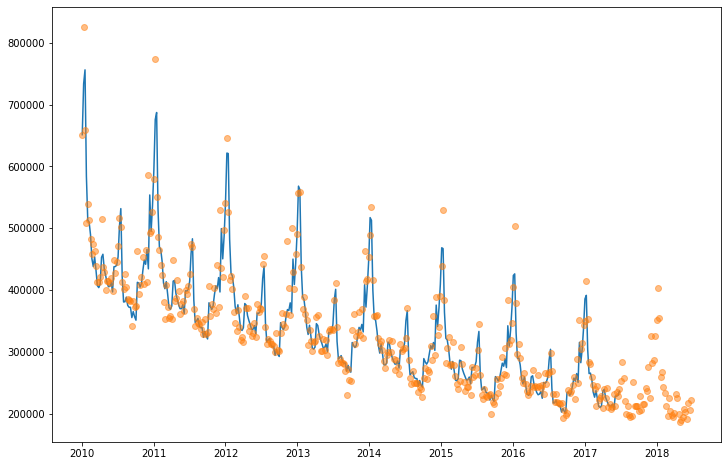

In [349]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
y = df[response_col]
plt.plot(train_df['week'], np.exp(yhat_in))
plt.plot(df['week'], df[response_col], 'o', alpha=0.5)

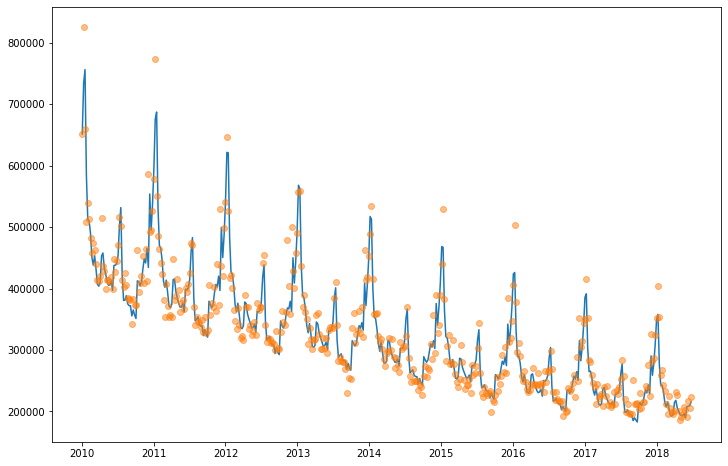

In [350]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
y = df[response_col]
plt.plot(df['week'], np.exp(yhat))
plt.plot(df['week'], df[response_col], 'o', alpha=0.5)

In [351]:
b_sm

array([[0.01974513, 0.07724208, 0.03243387, 0.02240853, 0.08306882,
        0.03311141, 0.06526658, 0.02104954, 0.08273529, 0.03102272,
        0.02012601, 0.07611009, 0.0842623 , 0.07757036, 0.03608077,
        0.076207  , 0.06185518, 0.0161138 , 0.08470803, 0.06144145,
        0.02435845, 0.01335111, 0.06701034, 0.01774842, 0.07349097,
        0.03953276, 0.07531412, 0.08191316, 0.05522989, 0.07190906,
        0.03361018, 0.07962033, 0.02153446, 0.01693627, 0.01669774,
        0.050111  , 0.01439328, 0.04282177, 0.02254611, 0.05472456,
        0.08783501, 0.01618419, 0.06618959, 0.07713463, 0.01604733,
        0.03926695, 0.01581514, 0.07223117, 0.01299351, 0.07844644,
        0.0526723 , 0.08035614]])

In [157]:
# predicted_df = mod.predict(df)

In [82]:
# predicted_df.tail(52)

In [95]:
np.exp(yhat[-52:])

array([259994.18728914, 276488.60966091, 221471.76732018, 198979.9161259 ,
       199515.61591593, 202477.9713338 , 195209.70798333, 193736.2724275 ,
       193563.92530879, 182983.17573655, 188827.04091572, 185896.91105326,
       182762.58140365, 210137.29279007, 216813.0284998 , 208931.12553233,
       213506.70615685, 223357.84117062, 238792.15801742, 229856.39461773,
       240825.82492172, 250043.58958707, 285263.0625196 , 259109.57015021,
       277689.73308499, 308823.31147867, 350510.96240829, 351444.8120778 ,
       275969.25774332, 241630.62005849, 241946.06192215, 231634.07768016,
       212978.18153321, 205576.71528896, 215233.77031575, 204946.84359329,
       192983.34299581, 192196.73063261, 193863.74076808, 213921.35316161,
       217231.54564023, 206060.03309932, 202006.84736471, 195286.1608117 ,
       194378.32206195, 193253.74265189, 196593.65819889, 190345.24592783,
       207353.46079695, 208076.63737087, 208899.12803863, 215357.00850345])

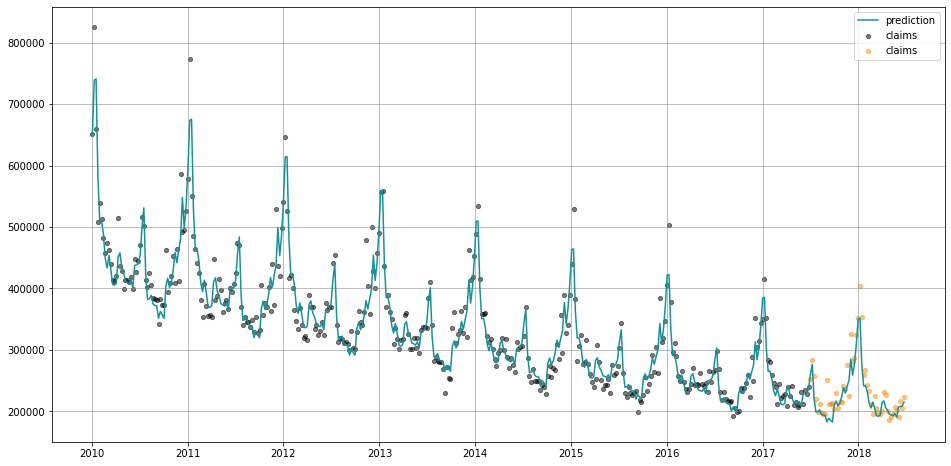

In [96]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=mod.date_col, actual_col=mod.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

In [97]:
# backtest on more data

# data = pd.read_csv('./data/uber_uscan_rider_uFT.csv', parse_dates=['event_week'])
# data = pd.read_csv('./data/uber_uscan_driver_uFT.csv', parse_dates=['event_week'])
# response_col = 'uFT'
# date_col='event_week'
# key_col = 'city_name'
# predicted_col='prediction'
# min_train_len = 380
# forecast_len = 26
# incremental_len = 13
# n_splits=2
# key_col = "city_name"
# window_type = 'expanding'
# seasonality=52

data = pd.read_csv('./data/m3_monthly.csv', parse_dates=['date'])
response_col = 'value'
date_col='date'
key_col = 'key'
predicted_col='prediction'
min_train_len = 380
forecast_len = 18
incremental_len = 18
n_splits=1
window_type = 'expanding'
seasonality=12

# data = pd.read_csv('./data/m4_weekly.csv', parse_dates=['date'])
# response_col = 'value'
# date_col='date'
# key_col = 'key'
# predicted_col='prediction'
# min_train_len = 380
# forecast_len = 13
# incremental_len = 13
# n_splits=1
# window_type = 'expanding'
# seasonality=52

In [98]:
seed=2020

In [99]:
data.dtypes

key              object
value           float64
date     datetime64[ns]
dtype: object

In [100]:
uni_keys = data[key_col].unique()

Instantiate a model that we want to backtest

In [106]:
mod = DLTRH(
    is_multiplicative=True, seed=seed,
    response_col=response_col, date_col=date_col, seasonality=seasonality, 
    normalize_seasonality=1,
    infer_method='map', predict_method='map')

In [107]:
%%time
bt_result, bt_scores = run_multi_series_backtest(
    data=data, 
    response_col=response_col, 
    key_col=key_col, 
    date_col=date_col,
    model=mod,
    min_train_len=min_train_len, 
    incremental_len=incremental_len, 
    forecast_len=forecast_len, 
    predicted_col=predicted_col, 
    n_splits=n_splits,
    window_type = window_type
)

100%|██████████| 1399/1399 [02:46<00:00,  8.41it/s]


CPU times: user 2min 32s, sys: 4.98 s, total: 2min 37s
Wall time: 2min 47s


In [108]:
bt_scores['smape'].mean()

0.15820130184405004

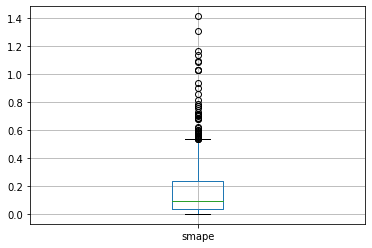

In [109]:
bt_scores.boxplot(column='smape')

In [45]:
mod2 = DLT(
    is_multiplicative=True, seed=seed,
    response_col=response_col, date_col=date_col, seasonality=seasonality, 
    infer_method='map', predict_method='map')

In [46]:
%%time
bt_result2, bt_scores2 = run_multi_series_backtest(
    data=data, 
    response_col=response_col, 
    key_col=key_col, 
    date_col=date_col,
    model=mod2,
    min_train_len=min_train_len, 
    incremental_len=incremental_len, 
    forecast_len=forecast_len, 
    predicted_col=predicted_col, 
    n_splits=n_splits,
    window_type = window_type
)

100%|██████████| 1399/1399 [02:02<00:00, 11.39it/s]


CPU times: user 1min 53s, sys: 5.8 s, total: 1min 59s
Wall time: 2min 4s


In [47]:
bt_scores2['smape'].mean()

0.14827365152127073

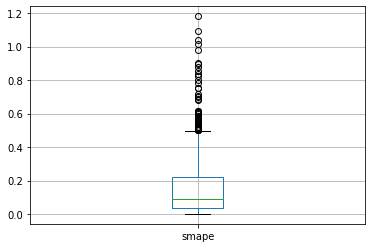

In [48]:
bt_scores2.boxplot(column='smape')

In [ ]:
# TODO:
# compare 
# 1. using normalize vs. not use -- non-normalized is better 
# 2. subtract init lev by s[1] vs. by s[SEASONALITY] -- after some thought, s[SEASONALITY]
# should be the right one
# 3. changing different ways to get init_lev prior -- using l[1] seems even worse
# 4. random initialize seasonality vs. random normal initialization -- not too much difference
# 5. changing NUs of student t to see if letting stan to optimize makes better accuracy <--- This is TODO!
# tried 10 vs. 5 doesn't matter (when normalizing)

# NOTES:
# it doesn't do as well as the original DLT but meanwhile does not do worse (improvment on rider but relatively similar in driver and slightly worse in M3 Monthly)